In [1]:
!git clone https://github.com/ZbynekAfiala/Stellar-classification.git

fatal: destination path 'Stellar-classification' already exists and is not an empty directory.


#Library import

In [2]:
!pip install sdss


from astropy.time import Time
from datetime import datetime, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sdss import Region
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression


import astropy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings
import xgboost as xgb


warnings.filterwarnings("ignore")

#Data Preprocessing & Exploratory Analysis



In [3]:
df = pd.read_csv('Stellar-classification/star_classification.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [6]:
df = df[(df["u"]!=-9_999) | (df["g"]!=-9_999) | (df["z"]!=-9_999)] # drops null values

In [7]:
# https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
df["date"] = pd.to_datetime(Time(df["MJD"], format='mjd').iso) #MJD = modified julian date
df["dayofyear"] = df["date"].dt.dayofyear - 1
df["dayofyear_norm"] = 2 * math.pi * df["dayofyear"] / 365
df["dayofyear_cos"] = np.cos(df["dayofyear"])
df["dayofyear_sin"] = np.sin(df["dayofyear"])

In [8]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,...,class,redshift,plate,MJD,fiber_ID,date,dayofyear,dayofyear_norm,dayofyear_cos,dayofyear_sin
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,...,GALAXY,0.634794,5812,56354,171,2013-03-03,61,1.050067,-0.258102,-0.966118
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,...,GALAXY,0.779136,10445,58158,427,2018-02-09,39,0.671354,0.266643,0.963795
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,...,GALAXY,0.644195,4576,55592,299,2011-01-31,30,0.516426,0.154251,-0.988032
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,...,GALAXY,0.932346,9149,58039,775,2017-10-13,285,4.906049,-0.633343,0.773872
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,...,GALAXY,0.116123,6121,56187,842,2012-09-17,260,4.475694,-0.730194,0.683240


In [9]:
d_class_str_to_int = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}


df['class'] = df['class'].map(d_class_str_to_int)
df['class'].value_counts()

0    59445
1    21593
2    18961
Name: class, dtype: int64

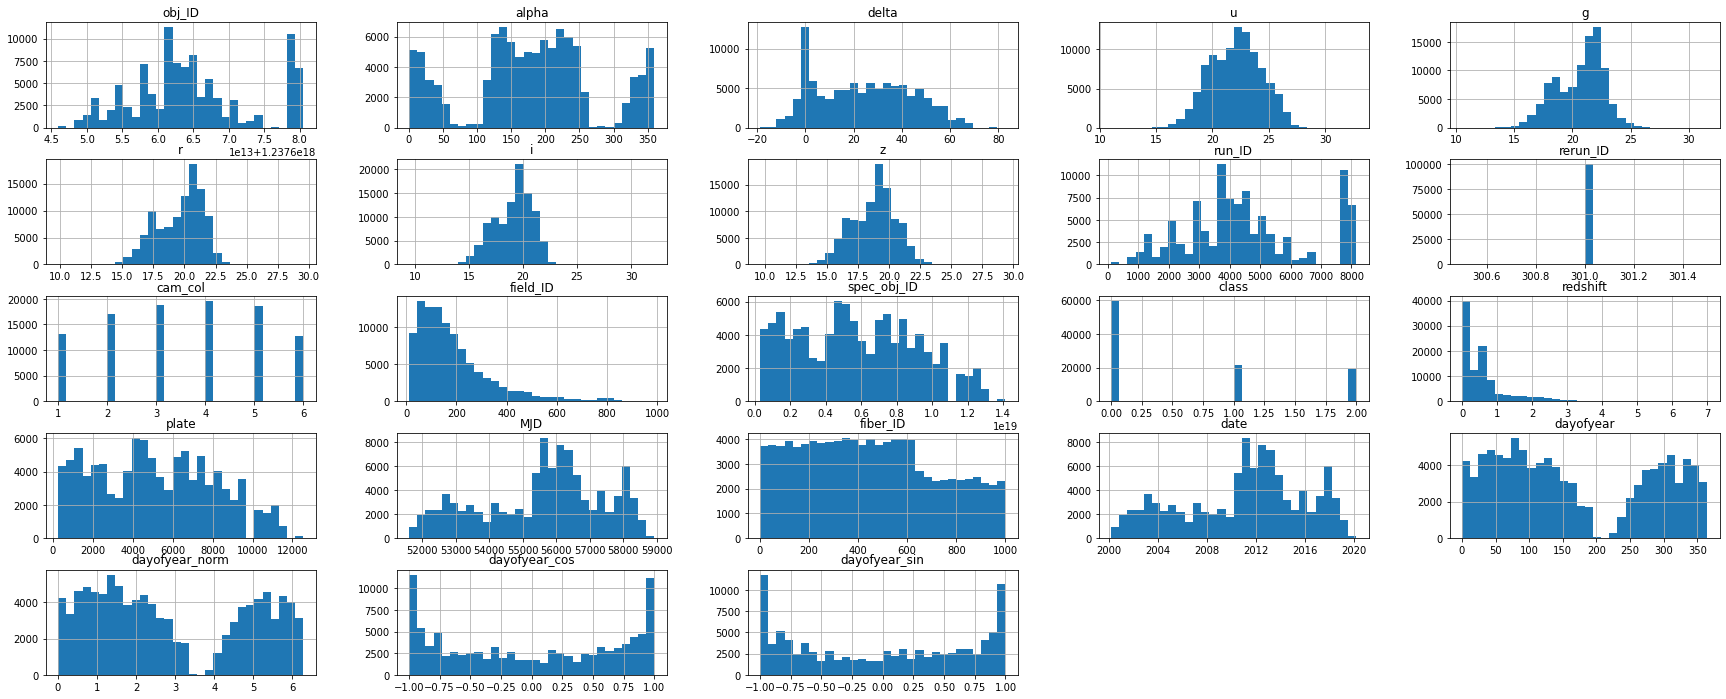

In [10]:
df.hist(bins=30, figsize=(30, 12))
plt.show()

galaxy


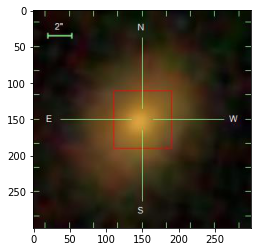

star


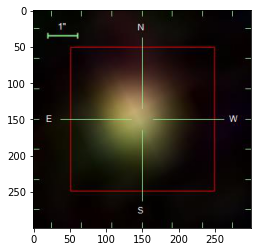

QSO


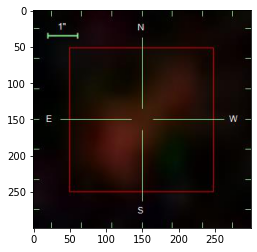

In [11]:
# df[df['class'] == 0].head()
# df[df['class'] == 1].head()
# df[df['class'] == 2].head()

print('galaxy')
ra = 345.282593
dec = 21.183866
reg = Region(ra, dec, fov=0.005)
reg.show()

print('star')
ra = 39.149691
dec = 28.102842
reg = Region(ra, dec, fov=0.002)
reg.show()

print('QSO')
ra = 340.995121
dec = 20.589476
reg = Region(ra, dec, fov=0.002)
reg.show()

#Model training

In [12]:
seed = 69


y = df['class']
X = df[['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']]


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.85,
    shuffle=True,
    random_state=seed,
    stratify=y
)


y_train = y_train.values.ravel()


pipeline_rfc = imbpipeline(
    steps = [
        ['smote', SMOTE(random_state=seed)],
        ['scaler', StandardScaler()],
        ['rfc', RandomForestClassifier(random_state=seed, n_jobs=-1)]
    ]
)


pipeline_lr = imbpipeline(
    steps = [
        ['smote', SMOTE(random_state=seed)],
        ['scaler', StandardScaler()],
        ['lr', LogisticRegression(random_state=seed)]
    ]
)


stratified_k_fold_rfc = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=seed
)


param_grid_rfc = {
    'rfc__max_samples': [0.7],
    'rfc__n_estimators': [18],
    'rfc__max_depth': [None],
}


hyper_grid_lr = {
    'lr__C':[0.001], #"best" grid
    'lr__multi_class':['multinomial'],
    'lr__max_iter':[100],
    'lr__penalty':['l2'],
    'lr__solver':['lbfgs']
}


grid_search_rfc = GridSearchCV(
    estimator=pipeline_rfc,
    param_grid=param_grid_rfc,
    cv=stratified_k_fold_rfc,
    scoring='accuracy',
    n_jobs=-1
)


grid_search_lr = GridSearchCV(
    estimator = pipeline_lr,
    param_grid = hyper_grid_lr,
    cv = 2,
    scoring = "accuracy"
)


scaler = StandardScaler()
scaler.fit(X_train)


LinearSVM = LinearSVC().fit(pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index), y_train)
print("LinearSVM trained")
XGB = xgb.XGBClassifier(random_state=seed).fit(pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index), y_train)
print("XGB trained")
rfc = grid_search_rfc.fit(X_train, y_train)
print("RFC trained")
grid_search_lr.fit(X_train,y_train)
print("LR trained")

LinearSVM trained
XGB trained
RFC trained
LR trained


# Model Evaluation

In [13]:
print(f"\nLogistic regression accuracy: {grid_search_lr.score(X_test, y_test) * 100}%")
print(f"LinearSVM accuracy: {LinearSVM.score(pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index), y_test) * 100}%")
print(f"XGB accuracy: {XGB.score(pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index), y_test) * 100}%")
print(f"RFC accuracy: {rfc.score(X_test, y_test) * 100}%")


Logistic regression accuracy: 83.81333333333333%
LinearSVM accuracy: 93.75333333333333%
XGB accuracy: 96.89999999999999%
RFC accuracy: 97.45333333333333%


In [14]:
y_pred = rfc.predict(X_test) #from the best model

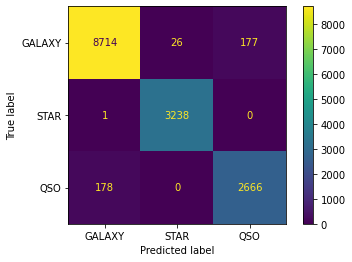

In [15]:
conf_matrix = confusion_matrix(pd.Series(y_test), y_pred)
mat_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["GALAXY","STAR","QSO"]) #0,1,2
mat_display.plot()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8917
           1       0.99      1.00      1.00      3239
           2       0.94      0.94      0.94      2844

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



In [17]:
for feature, importance in sorted(zip(X.columns, rfc.best_estimator_.named_steps['rfc'].feature_importances_), key = lambda t: t[1], reverse=True):
    print(f'{feature}:\t{importance:.5f}'.expandtabs(16))


redshift:       0.68748
z:              0.07585
i:              0.06623
g:              0.06526
u:              0.03791
r:              0.03133
MJD:            0.02229
delta:          0.00703
alpha:          0.00663
